In [1]:
# NOTE:
# Regular PINN.
# Use phys_loss_weight to set the weight of the physics loss 

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import random
import sys

#from model import PINN

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


/mn/stornext/d8/data/dennisfr/PINN/S-Star-PINN/src/SLoader.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.u = torch.tensor(self.u, dtype=torch.float32)


Text(0.5, 0, '$x$ [100 AU]')

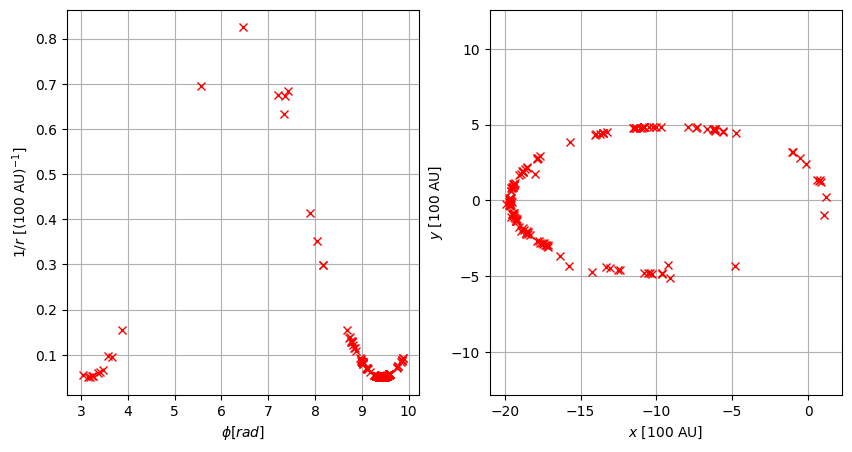

In [3]:
from src.SLoader import SLoader

loader = SLoader(scaling=1e-2)

u = loader.u
phi = loader.phi


fig, ax = plt.subplots(ncols=2, figsize=(10,5))
ax[0].plot(loader.phi, loader.u, 'rx')
ax[0].grid()
ax[0].set_xlabel(r"$\phi [rad]$")
ax[0].set_ylabel(r"$1/r$ [(100 AU)$^{-1}$]")

ax[1].plot(loader.x, loader.y, 'rx')
ax[1].grid()
ax[1].axis('equal');
ax[1].set_ylabel(r"$y$ [100 AU]")
ax[1].set_xlabel(r"$x$ [100 AU]")



In [15]:

def grad(out, inp):
    return torch.autograd.grad(out, 
                               inp, 
                               grad_outputs=torch.ones_like(out), 
                               create_graph=True,
                               allow_unused=True)

sys.path.append("/mn/stornext/d8/data/dennisfr/myResearch/KAN/")
from KAN import KAN


class NNBlock(nn.Module):
    """
    Standard Feed Forward Neural Network 
    """
    def __init__(self, in_chan, out_chan, chans=[5,10,5], dropout_prob=0.1):
        super().__init__()

        #self.in_block = nn.Linear(in_chan, chans[0])

        layers = []

        layers.append(nn.Linear(in_chan, chans[0]))
        layers.append(nn.Tanh())
        #layers.append(nn.Dropout(p=dropout_prob))

        for i in range(len(chans) - 1):
            layers.append(nn.Linear(chans[i], chans[i+1]))
            layers.append(nn.Tanh())
            #layers.append(nn.Dropout(p=dropout_prob))

        layers.append(nn.Linear(chans[-1], out_chan))

        self.blocks = nn.Sequential(*layers)

    def forward(self, x):
        #y = torch.sin(self.in_block(x))
        #return self.blocks(y)
    
        return self.blocks(x)


class PINN(nn.Module):
    """
    Physics Informed Neural Network. 
        * physical_loss :
            Calculates the physical loss using 
            - returns torch.tensor
    """
    def __init__(self, in_chan=1, out_chan=1, chans=[5,10,5]):
        super().__init__()
        #self.nn = NNBlock(in_chan, out_chan, chans=chans)
        self.nn = KAN([in_chan, *chans, out_chan])

        self.e_  = torch.nn.Parameter(torch.abs(torch.randn(1)/10))
        self.mu_ = torch.nn.Parameter(torch.abs(torch.randn(1)/10))
        self.M_  = torch.nn.Parameter(torch.abs(torch.randn(1)/10))
        self.delta_ = torch.nn.Parameter(torch.abs(torch.randn(1)/10))
        self.lambda_ = torch.nn.Parameter(torch.abs(torch.randn(1)/10))
        
        #self.delta_ = torch.nn.Parameter(torch.tensor(0.0001))
        #self.lambda_ = torch.nn.Parameter(torch.tensor(1000.0))

    def forward(self, x):
        mu = self.get_mu()
        M  = self.get_M()
        e  = self.get_e()

        delta = self.get_delta()
        lmbda = self.get_lambda()

        Y = delta/(lmbda*(1+delta))

        u = mu/M * (1 + e*torch.cos(self.nn(x))) 
        #u = mu/M * (1 + e*torch.cos(self.nn(x)) + 
        #    torch.sqrt(((1 + e*torch.cos(self.nn(x))) * (1 - 4*M/mu*Y + e*torch.cos(self.nn(x)))).abs_())
        #    )/2
        return u
    
    def get_e(self):
        #return torch.abs(self.e_)
        #return torch.tanh(torch.abs(self.e_[0]*self.e_[1] + self.e_[2]))
        return torch.abs(self.e_)
    
    def get_M(self):
        return torch.abs(self.M_)
        #return torch.exp(self.M_)
    
    def get_mu(self):
        return torch.abs(self.mu_)
        #return torch.exp(self.mu_)
    
    def get_p(self):
        return self.get_M()/self.get_mu()
        #return self.M_/self.mu_
        #return torch.exp(self.p_)

    def get_delta(self):
        #return torch.abs(self.delta_)
        return torch.abs(self.delta_)
    
    def get_lambda(self):
        return torch.abs(self.lambda_)

    def physical_loss(self, phi, lambda1=1., lambda2=1.):
        chi = self.nn(phi)
        
        M  = self.get_M()
        mu = self.get_mu()
        e  = self.get_e() #.item()

        delta = self.get_delta()
        lmbda = self.get_lambda()

        #u = mu/M * (1 + e*torch.cos(chi))

        #dchi = grad(chi, phi)[0] # dchi/dphi = dchi/du * du/dphi = du/dphi * du/dchi
        #ddchi = grad(dchi, phi)[0]

        dchi = torch.autograd.grad(chi, phi, 
                               grad_outputs=torch.ones_like(chi), 
                               create_graph=True,
                               allow_unused=True)[0]
        
        ddchi = torch.autograd.grad(dchi, 
                               phi, 
                               grad_outputs=torch.ones_like(dchi), 
                               create_graph=True)[0]
    

        #ode1 = dchi**2 - (1 - 2*mu*(3 + e*torch.cos(chi)))
        ode1 = dchi**2 - (1 - 2*mu*(3 + e*torch.cos(chi))) - 2*M*delta/(lmbda*(1 + delta))
        ode2 = ddchi - mu*e*torch.sin(chi)

        # L2 Loss
        loss1 = torch.mean(ode1**2)
        loss2 = torch.mean(ode2**2)

        # L1 Loss
        #loss1 = torch.mean(ode1)
        #loss2 = torch.mean(ode2)

        # Inverse loss
        #loss1 = torch.mean(1/(ode1 + 1e-6)**2)
        #loss2 = torch.mean(1/(ode2 + 1e-6)**2)
        
        loss1 *= lambda1
        loss2 *= lambda2

        return loss1 + loss2

In [16]:
# Initialize model
lr = 1e-3

model = PINN(1, 1, chans=[5]*5).to(device)

optimizer = optim.AdamW(lr=lr, params=model.parameters())#, weight_decay=0.0)
# Adamw 
#criterion = nn.MSELoss()
criterion = nn.L1Loss()

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', 
                patience=500, threshold=0.0001, verbose=True, cooldown=200)


losses = [[], []]
params = [[], [], [], [], []]

N = 2.  # How many pi do I want to extend the angles with, when evaluating the physics
phi_lin = torch.linspace(phi.min() - torch.pi*N, phi.max() + torch.pi*N, steps=256).view(-1,1).requires_grad_(True)

phys_loss_weight = 1e-1
#phys_loss_weight = 1e-1

batch_size = 128
batch_size_phys = 128

epoch = 0

In [17]:
epochs = 5_000

for i in tqdm(range(epochs)):
    epoch += 1
    ind = torch.tensor(random.sample(range(len(phi)), batch_size))
    ind_p = torch.tensor(random.sample(range(len(phi_lin)), batch_size_phys))

    phi_ = phi[ind]
    #if epoch < epoch_start:
    #phi_ = (phi_ + (torch.randint(low=0,high=3,size=phi_.shape) - 1) * 2 * torch.pi)
    
    u_ = u[ind]
    phi_lin_ = phi_lin[ind_p]

    phi_ = phi_.to(device)
    u_ = u_.to(device)
    phi_lin_ = phi_lin_.to(device)
    
    out = model(phi_)

    MSEloss = criterion(out, u_)
    #MSEloss = criterion(torch.log(out), torch.log(u_))
    #MSEloss = criterion(1/out, 1/u_)    # Minimize difference in r
    #MSEloss = criterion(torch.log(out + 1e-8), torch.log(u + 1e-8))    # Minimize relative difference
    #MSEloss = torch.mean(torch.abs(out - u)**2 / (torch.abs(u) + 1e-8))    # Minimize MSE weightet by r

    #phi_lin = (torch.randn(1000, 1, requires_grad=True) * 10).to(device)
    PHYSloss = phys_loss_weight * model.physical_loss(phi_lin_)
    #PHYSloss = phys_loss_weight * model.physical_loss(phi_aug)
    #phys_loss_weight *= 1.005
    #phys_loss_weight = min(phys_loss_weight, max_phys_loss_weight)

    losses[0].append(MSEloss.item())
    losses[1].append(PHYSloss.item())

    loss = MSEloss + PHYSloss

    optimizer.zero_grad()
    loss.backward()
    #if epoch % 2 == 0:
    #    MSEloss.backward()
    #else:
    #    PHYSloss.backward()
    #MSEloss.backward()
    #PHYSloss.backward()
    optimizer.step()
    #scheduler.step(loss)

    params[0].append(model.get_e().item())
    params[1].append(model.get_mu().item())
    params[2].append(model.get_M().item())
    
    params[3].append(model.delta_.item())
    params[4].append(model.lambda_.item())


100%|██████████| 5000/5000 [02:36<00:00, 32.01it/s]


0.1
tensor(0.0011, grad_fn=<MeanBackward0>)
tensor(0.0007, grad_fn=<MeanBackward0>)


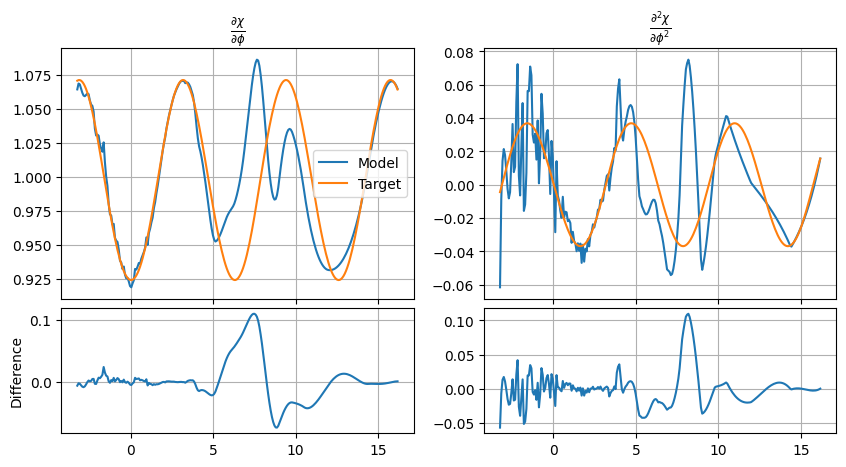

In [26]:
def grad(out, inp):
    return torch.autograd.grad(out, 
                               inp, 
                               grad_outputs=torch.ones_like(out), 
                               create_graph=True)

_phi = phi_lin # torch.linspace(-2*torch.pi, 4*torch.pi, steps=1000).view(-1,1).requires_grad_(True)
chi = model.nn(_phi)

mu = model.get_mu().item()
#p  = self.get_p()
M  = model.get_M()
e  = model.get_e().item()

dchi = grad(chi, _phi)[0]
ddchi = grad(dchi, _phi)[0]

tgt1 = (1 - 2*mu*(3 + e*torch.cos(chi))) + 2*M*model.delta_/(model.lambda_ + model.lambda_*model.delta_)
ode1 = dchi**2 - tgt1

tgt2 = mu*e*torch.sin(chi)
ode2 = ddchi - tgt2

print(phys_loss_weight)
print(torch.mean(ode1**2))
print(torch.mean(ode2**2))

_phi = _phi.detach().numpy()
dchi = dchi.detach().numpy()
ddchi = ddchi.detach().numpy()
chi = chi.detach()
ode1 = ode1.detach().numpy()
ode2 = ode2.detach().numpy()
tgt1 = tgt1.detach().numpy()
tgt2 = tgt2.detach().numpy()

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10,5), gridspec_kw={'height_ratios':[2,1]}, sharex=True)
ax[0,0].grid()
ax[0,0].set_title(r"$\frac{\partial \chi}{\partial \phi}$")
ax[0,0].plot(_phi, dchi**2, label="Model")
ax[0,0].plot(_phi, tgt1, label="Target")
ax[0,0].legend()

ax[0,1].grid()
ax[0,1].set_title(r"$\frac{\partial^2 \chi}{\partial \phi^2}$")
ax[0,1].plot(_phi, ddchi)
ax[0,1].plot(_phi, tgt2)

ax[1,0].grid()
ax[1,0].set_ylabel("Difference")
ax[1,0].plot(_phi, ode1)

ax[1,1].grid()
ax[1,1].plot(_phi, ode2)

plt.subplots_adjust(hspace=.05)

e = 0.88364177942276
p = 2.2867634296417236
M = 0.09539565443992615
mu = 0.041716448962688446
delta = 0.13647785782814026
lambda = 0.09236953407526016
M-model-data = 0.9882978796958923


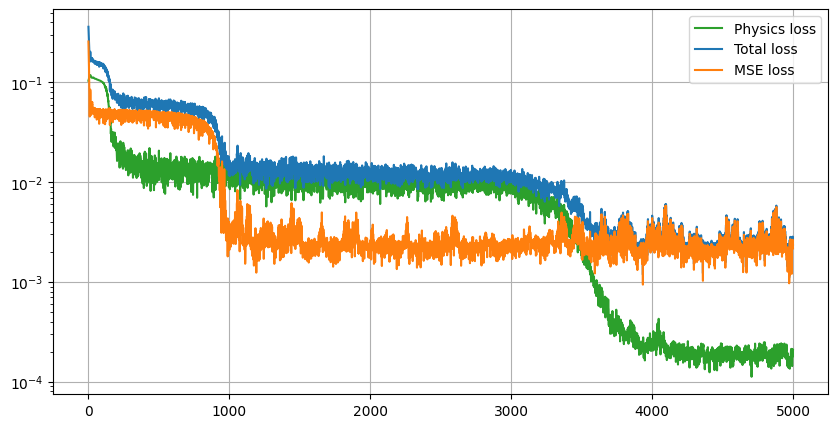

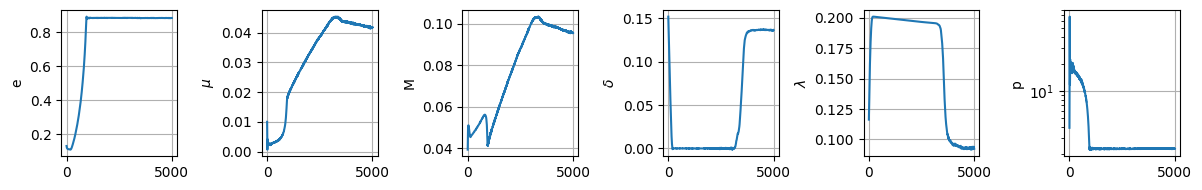

In [27]:
print("e =", model.get_e().item())
#print("p =", model.get_M().item()/model.get_mu().item())
print("p =", model.get_p().item())
print("M =", model.get_M().item())
print("mu =", model.get_mu().item())

print("delta =", model.delta_.item())
print("lambda =", model.lambda_.item())

M_md = torch.mean(1 - torch.abs(model(phi.to(device)).cpu() - u)/u).item()
print("M-model-data =", M_md)


fig, ax = plt.subplots(figsize=(10,5))

ax.plot(losses[1], label="Physics loss", c="tab:green")
ax.plot(np.array(losses[0]) + np.array(losses[1]), label="Total loss", c="tab:blue")
ax.plot(losses[0], label="MSE loss", c="tab:orange")

ax.grid()
ax.legend()
ax.set_yscale("log")
plt.show()


fig, ax = plt.subplots(ncols=len(params)+1, figsize=(12,2))

p_label = ["e", r"$\mu$", "M", r"$\delta$", r"$\lambda$"]

for i in range(len(params)):
    ax[i].plot(params[i])
    ax[i].set_ylabel(p_label[i])
    ax[i].grid()


ax[-1].plot(np.array(params[2])/np.array(params[1]))
ax[-1].set_ylabel("p")
ax[-1].grid()
ax[-1].set_yscale("log")


plt.tight_layout()
plt.show()

# e  ~ 0.884 (0.884)
# p  ~ 228 (223)
# mu ~ 1.8e-4
# M  ~ 0.04239 AU

# M-model-data ~ 0.9755

# print(model.get_p().item() / (1 - model.get_e().item()**2) * 1e-2)

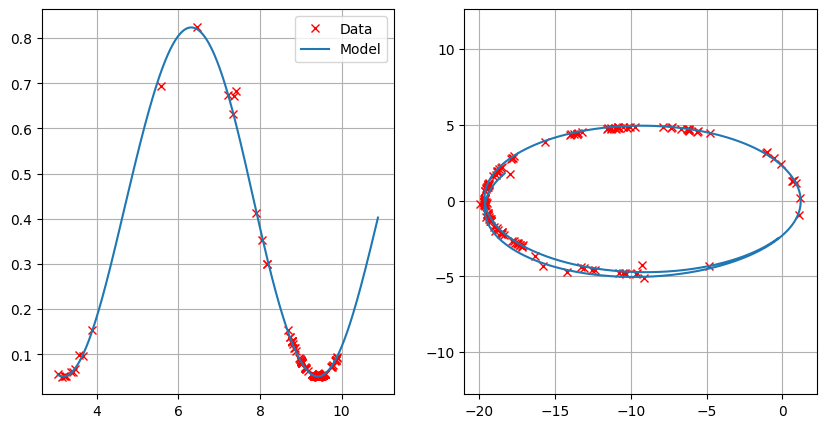

In [28]:
fig, ax = plt.subplots(figsize=(10,5), ncols=2)
_phi = phi
_u = u
ax[0].plot(_phi, _u, 'rx', label="Data")


theta = torch.linspace(_phi.min(), _phi.max()+1, steps=1000, dtype=torch.float32).to(device)
u_ = model(theta.unsqueeze(1)).cpu().detach().numpy()[:,0]
theta = theta.cpu()
ax[0].plot(theta, u_, label="Model")
#ax[0].vlines(torch.pi/2, _u.min(), _u.max(), 'k', ls='--')
#ax[0].vlines(3*torch.pi/2, _u.min(), _u.max(), 'k', ls='--')
#ax[0].vlines(2*torch.pi, _u.min(), _u.max(), 'r', ls='--')
#ax[0].vlines(torch.pi, _u.min(), _u.max(), 'r', ls='--')


#ax[1].plot(x1, y1, 'rx')
#ax[1].plot(x2, y2, 'rx')
ax[1].plot(torch.cos(_phi[:,0])/_u[:,0], torch.sin(_phi[:,0])/_u[:,0], "rx")

r = 1/u_

theta = theta.numpy()
ax[1].plot(r*np.cos(theta), r*np.sin(theta));


# e  ~ 0.884 (0.884)
# p  ~ 228 (223)
# mu ~ 1.8e-4
# M  ~ 0.04239 AU
#u_test = 1/228 * (1 + 0.884*torch.cos(model.nn(torch.tensor(theta).unsqueeze(1)))).detach().numpy()[:,0]
#ax[0].plot(theta, u_test, label="Target?")
#ax[1].plot(np.cos(theta)/u_test, np.sin(theta)/u_test)


[axi.grid() for axi in ax]
ax[1].axis('equal')
#ax[0].axis('equal')
ax[0].legend();
#ax.set_xscale("log")
#ax[0].set_xlim(0,3)
#ax[0].set_ylim(0,2)

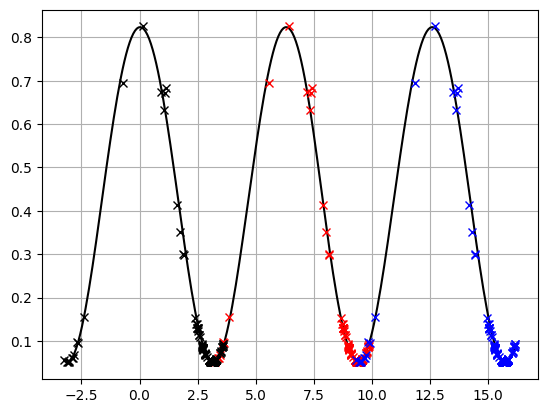

In [29]:
fig, ax = plt.subplots()
ax.grid()

u_ = model(phi_lin).cpu().detach().numpy()[:,0]
theta = phi_lin.cpu().detach().numpy()

ax.plot(theta[:,0], u_, 'k')


ax.plot(phi.cpu(), u.cpu(), "rx")
phi_aug_ = phi + 2 * torch.pi
ax.plot(phi_aug_.cpu(), u.cpu(), 'bx')
phi_aug = phi - 2 * torch.pi
ax.plot(phi_aug.cpu(), u.cpu(), 'kx')

#plt.xlim(-2, -1)
#r = 1/u_
#theta = phi_lin.detach().numpy()
#ax.plot(r*np.cos(theta[:,0]), r*np.sin(theta[:,0]));


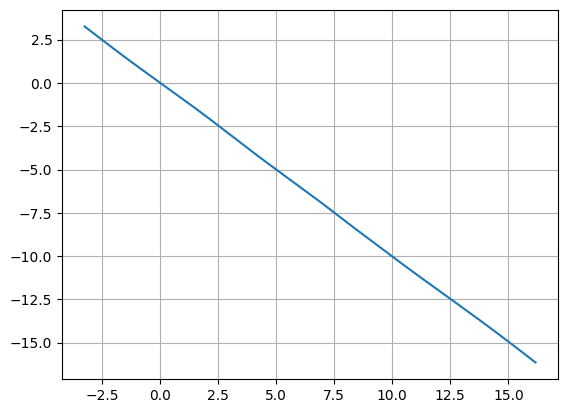

In [30]:
x = phi_lin
y = model.nn(x)

x = x.cpu().detach().numpy()
y = y.cpu().detach().numpy()

plt.plot(x,y)
plt.grid()

In [23]:
state = {
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict(),
}

#torch.save(state, f'states/S2-Y-GINN.pth')